# Goals
- Access and filter DESI EDR galaxy spectra data from a database using SPARCL.
- Process and normalize the spectra data to prepare it for model training.
- Develop a CNN autoencoder with skip connections to perform dimensionality reduction and reconstruction of the spectra.
- Train the autoencoder model using a weighted mean squared error (MSE) loss function to emphasize critical spectral features.
- Identify and visualize anomalies in the galaxy spectra based on high reconstruction errors.
- Provide visual representations of detected anomalies and evaluate the model's performance through training loss metrics.


# Summary
This project leverages the Dark Energy Spectroscopic Instrument (DESI) Early Data Release (EDR) dataset to train a Convolutional Neural Network (CNN) autoencoder for anomaly detection in galaxy spectra. The code retrieves galaxy spectra data from a database, processes and normalizes it, and then applies an autoencoder with skip connections to reconstruct the spectra. The reconstruction errors are used to identify anomalous spectra, which may indicate unusual features or observational issues in the data.

# Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from sparcl.client import SparclClient
from dl import queryClient as qc, authClient as ac
from getpass import getpass
import os
import re
import torch.nn.functional as F
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator  # Use AutoMinorLocator from ticker
from torchviz import make_dot




In [2]:
# Configure file directories
DATA_DIR = '/Users/elicox/Desktop/Mac/Work/Yr4 Work/Project/CNN-auto/'
IMG_DIR = os.path.join(DATA_DIR, 'output_images')
CSV_PATH = os.path.join(DATA_DIR, 'spectra_data.csv')
os.makedirs(IMG_DIR, exist_ok=True)
#os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin" # uncomment when CNN visualisation is needed

# Initialize SPARCL client
client = SparclClient()

# Data Loading and Saving Functions

In [3]:
# Function to query the database
def query_spectra_data():
    """
    Queries the DESI EDR database to retrieve primary galaxy spectra.
    Returns a DataFrame with the spectra data.
    """
    query = """
    SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
           zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
           zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
           zp.desi_target, zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
    FROM desi_edr.zpix AS zp
    WHERE zp.zcat_primary = 't'
      AND zp.zcat_nspec > 3
      AND zp.spectype = 'GALAXY'
    """
    try:
        zpix_cat = qc.query(sql=query, fmt='table')
        df = zpix_cat.to_pandas()
        print(f"Retrieved {len(df)} records from the database.")
        return df
    except Exception as e:
        print(f"Error querying data: {e}")
        return None

# Save DataFrame to CSV
def save_to_csv(df, path=CSV_PATH):
    """
    Saves the spectra DataFrame to a CSV file at the specified path.
    """
    try:
        df.to_csv(path, index=False)
        print(f"Data saved to {path}")
    except Exception as e:
        print(f"Error saving data to file: {e}")

# Load spectra data from CSV
def load_spectra_data():
    """
    Loads spectra data from a CSV file. Returns a DataFrame if successful, else None.
    """
    try:
        data = pd.read_csv(CSV_PATH)
        print(f"Data loaded from {CSV_PATH}")
        return data
    except FileNotFoundError:
        print(f"File not found: {CSV_PATH}")
        return None
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        return None


# Optionally load from database or CSV file
def load_or_fetch_spectra_data():
    """
    Prompts the user to query data from the database or load from a local CSV file.
    Optionally saves the data to file if requested.
    """
    user_choice = input("Do you want to try querying the database first? (y/n): ").strip().lower()
    
    if user_choice == "y":
        zpix_cat = query_spectra_data()
        if zpix_cat is not None:
            # Ask only if query was successful
            save_file_query = input("Do you want to save the data to a file? (y/n): ").strip().lower()
            if save_file_query == "y":
                save_to_csv(zpix_cat)
            return zpix_cat
        else:
            print("Query failed. Attempting to load data from file instead...")
    
    # Fallback to loading from file
    return load_spectra_data()


# Data Preparation Functions

In [4]:
# Process spectra data
def process_spectra_data(zpix_cat):
    """
    Processes the spectra data by normalizing flux values for each target.
    Returns a list of normalized flux arrays.
    """
    all_fluxes = []
    for i in tqdm(range(len(zpix_cat)), desc="Processing spectra"):
        targetid = int(zpix_cat['targetid'].iloc[i])
        
        inc = ['specid', 'redshift', 'flux', 'wavelength', 'spectype', 
               'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
        res = client.retrieve_by_specid(specid_list=[targetid], include=inc, dataset_list=['DESI-EDR'])
        
        best_spectra_fluxes = []
        for record in res.records:
            if record['specprimary']:
                flux = record['flux']
                flux_min, flux_max = np.min(flux), np.max(flux)
                flux_norm = (flux - flux_min) / (flux_max - flux_min)
                best_spectra_fluxes.append(flux_norm)
        
        all_fluxes.extend(best_spectra_fluxes)
    return all_fluxes


# Pad spectra data
def pad_spectra(fluxes, target_length):
    """
    Pads or truncates each flux array to match the target length.
    Returns a numpy array of padded flux data.
    """
    padded_fluxes = []
    num_padded = 0  # Track only the padded spectra

    for flux in fluxes:
        if len(flux) < target_length:
            padding = np.zeros(target_length - len(flux))
            padded_flux = np.concatenate([flux, padding])
            num_padded += 1
        else:
            padded_flux = flux[:target_length]
        padded_fluxes.append(padded_flux)

    if num_padded > 0:
        print(f"Padding applied to {num_padded} spectra to match the target length.")
    else:
        print("No padding was necessary; all spectra are of equal length.")

    return np.array(padded_fluxes)

# Create padding mask
def create_padding_mask(fluxes, target_length):
    """
    Generates a binary mask for padded values in the flux arrays.
    Used in the loss calculation to ignore padded regions.
    """
    masks = []
    for flux in fluxes:
        mask = np.ones_like(flux)
        if len(flux) < target_length:
            mask = np.concatenate([mask, np.zeros(target_length - len(flux))])
        masks.append(mask[:target_length])
    return np.array(masks)


# Autoencoder Model Definition

In [5]:
# CNN Autoencoder with skip connections
class CNNAutoencoderWithSkip(nn.Module):
    """
    A CNN-based autoencoder with skip connections to reconstruct spectra data.
    Includes batch normalization and leaky ReLU activation for stability.
    """
    def __init__(self):
        super(CNNAutoencoderWithSkip, self).__init__()
        # Encoder layers
        self.encoder1 = nn.Conv1d(1,128, kernel_size=3, stride=2, padding=1)
        self.encoder2 = nn.Conv1d(128, 64, kernel_size=3, stride=2, padding=1)
        self.encoder3 = nn.Conv1d(64, 32, kernel_size=3, stride=2, padding=1)
        self.encoder4 = nn.Conv1d(32, 16, kernel_size=3, stride=2, padding=1) 

        # Decoder layers with skip connections
        self.decoder4 = nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.decoder3 = nn.ConvTranspose1d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder2 = nn.ConvTranspose1d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder1 = nn.ConvTranspose1d(128, 1, kernel_size=3, stride=2, padding=1, output_padding=0)

    def forward(self, x):
        # Encoding with skip connections
        x1 = F.relu(self.encoder1(x))  # Save this for skip connection
        x2 = F.relu(self.encoder2(x1))  # Save this for skip connection
        x3 = F.relu(self.encoder3(x2))  # Save this for skip connection
        x4 = F.relu(self.encoder4(x3))  # Last encoding layer

        # Decoding with skip connections, ensuring matching tensor sizes
        x = F.relu(self.decoder4(x4))

        # Adjust sizes for skip connection with x3
        if x3.size(2) > x.size(2):
            x3 = x3[:, :, :x.size(2)]
        elif x3.size(2) < x.size(2):
            x = x[:, :, :x3.size(2)]
        x = F.relu(self.decoder3(x + x3))

        # Adjust sizes for skip connection with x2
        if x2.size(2) > x.size(2):
            x2 = x2[:, :, :x.size(2)]
        elif x2.size(2) < x.size(2):
            x = x[:, :, :x2.size(2)]
        x = F.relu(self.decoder2(x + x2))

        # Adjust sizes for skip connection with x1
        if x1.size(2) > x.size(2):
            x1 = x1[:, :, :x.size(2)]
        elif x1.size(2) < x.size(2):
            x = x[:, :, :x1.size(2)]
        x = self.decoder1(x + x1)

        return torch.sigmoid(x)

# Custom Loss Function


In [6]:
# Custom weighted MSE loss function
def weighted_mse_loss(output, target, mask, weight_factor=10):
    """
    Calculates MSE loss, amplifying high-residual areas with weight based on spectral gradient.
    """
    mse_loss = (output - target) ** 2
    gradient = torch.abs(target[:, :, 1:] - target[:, :, :-1])
    weighted_loss = mse_loss[:, :, 1:] * (1 + weight_factor * gradient)
    return (weighted_loss * mask[:, :, 1:]).mean()


# Training the Model


In [7]:
def train_autoencoder(model, data, mask, epochs=50, batch_size=64, lr=0.001): # do I need to change the batch size here as there has been another layer in the encoder that has gone to 128 not 64, the fuck does lr mean
    """
    Trains the model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(data), batch_size):
            batch_data, mask_batch = data[i:i+batch_size], mask[i:i+batch_size]
            optimizer.zero_grad()
            loss = weighted_mse_loss(model(batch_data), batch_data, mask_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(data):.4f}")

# Anomaly Detection and Visualization


In [8]:
# Create dynamic save path with numbering
def create_save_path(save_directory, base_filename):
    """
    Creates a new file path in the specified directory with a unique numeric suffix.
    Ensures saved file names are sequentially numbered.
    """
    os.makedirs(save_directory, exist_ok=True)
    existing_files = os.listdir(save_directory)
    numbers = [
        int(re.search(r'\d+', f).group())
        for f in existing_files if re.search(fr'{base_filename}_(\d+)\.png', f)
    ]
    next_number = max(numbers) + 1 if numbers else 1
    return os.path.join(save_directory, f'{base_filename}_{next_number}.png')


In [9]:
# Detect anomalies in  --- feels like this could be optimised 
def detect_anomalous_regions(original_fluxes, reconstructed_fluxes, window_size=50, percentile_threshold=95, range_mismatch_factor=1.5, overall_anomaly_threshold=0.3):
    """
    Identifies anomalous regions within spectra using residuals and a mismatch factor.
    """
    num_spectra, spectrum_length = original_fluxes.shape
    absolute_residuals = np.abs(original_fluxes - reconstructed_fluxes)
    relative_residuals = np.abs((original_fluxes - reconstructed_fluxes) / (original_fluxes + 1e-5))

    abs_residual_threshold = np.percentile(
        [np.mean(absolute_residuals[:, i:i+window_size], axis=1)
        for i in range(0, spectrum_length - window_size + 1, window_size // 2)], percentile_threshold)
    rel_residual_threshold = np.percentile(
        [np.mean(relative_residuals[:, i:i+window_size], axis=1)
        for i in range(0, spectrum_length - window_size + 1, window_size // 2)], percentile_threshold)
    
    anomalies, spectrum_anomalies = [], np.zeros(num_spectra, dtype=bool)
    for i in range(num_spectra):
        spectrum_anomalies_count = 0
        spectrum_anomaly_flags = np.zeros(spectrum_length, dtype=bool)
        
        for start in range(0, spectrum_length - window_size + 1, window_size // 2):
            end = start + window_size
            window_abs_residual, window_rel_residual = np.mean(absolute_residuals[i, start:end]), np.mean(relative_residuals[i, start:end])
            original_range, reconstructed_range = np.ptp(original_fluxes[i, start:end]), np.ptp(reconstructed_fluxes[i, start:end])
            
            if (window_abs_residual > abs_residual_threshold or
                window_rel_residual > rel_residual_threshold or
                reconstructed_range > original_range * range_mismatch_factor):
                spectrum_anomaly_flags[start:end] = True
                spectrum_anomalies_count += end - start

        spectrum_anomalies[i] = spectrum_anomalies_count / spectrum_length > overall_anomaly_threshold
        anomalies.append(spectrum_anomaly_flags)
    return anomalies, spectrum_anomalies

def plot_spectra(original_fluxes, reconstructed_fluxes, anomalous_regions, spectrum_anomalies, zpix_cat, wavelengths=None, save_directory='output_images'):
    """
    Plots the original and reconstructed spectra, highlighting anomalies and saving to a dynamic path.
    """
    num_samples = len(original_fluxes)
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6 * num_samples), sharex=True)
    
    if num_samples == 1:
        axes = [axes]  # Ensure axes is always iterable even for one sample

    for i, ax in enumerate(axes):
        x_axis = wavelengths if wavelengths is not None else range(len(original_fluxes[i]))
        
        # Plot original and reconstructed spectra
        ax.plot(x_axis, original_fluxes[i], label="Original", color='#2c7bb6', linewidth=0.5)
        ax.plot(x_axis, reconstructed_fluxes[i], label="Reconstructed", color='#d7191c', alpha=0.7, linewidth=0.5)

        # Highlight anomalous regions in the spectrum
        in_anomaly, anomaly_start = False, 0
        for j in range(len(x_axis)):
            if anomalous_regions[i][j] and not in_anomaly:
                anomaly_start = j
                in_anomaly = True
            elif not anomalous_regions[i][j] and in_anomaly:
                ax.axvspan(x_axis[anomaly_start], x_axis[j], color='#fdae61', alpha=0.7)
                in_anomaly = False
        if in_anomaly:
            ax.axvspan(x_axis[anomaly_start], x_axis[-1], color='#fdae61', alpha=0.7)

        # Set background color if the spectrum is anomalous
        if spectrum_anomalies[i]:
            ax.set_facecolor('#fee090')  # Yellow background for anomalous spectra
            ax.set_title(f"Spectrum {i+1} (ID: {zpix_cat['targetid'].iloc[i]}) - Anomalous", color='red')
        else:
            ax.set_title(f"Spectrum {i+1} (ID: {zpix_cat['targetid'].iloc[i]})", color='black')

        # Add residuals plot
        divider = make_axes_locatable(ax)
        ax_residual = divider.append_axes("bottom", size="25%", pad=0, sharex=ax)
        ax_residual.plot(x_axis, original_fluxes[i] - reconstructed_fluxes[i], color='#4dac26', linewidth=0.5)
        ax_residual.set_ylabel("Residuals")
        ax.set_ylabel("Flux (normalized)")
        ax.legend()

    plt.xlabel("Wavelength (Å)")
    plt.tight_layout()
    save_path = create_save_path(save_directory, 'spectra_reconstruction')
    plt.savefig(save_path, dpi=300)
    print(f"Figure saved to {save_path}")
    plt.show()


In [10]:
# Visualize the full autoencoder
def visualize_autoencoder(autoencoder, input_data):
    """
    Visualizes the entire autoencoder model structure, saving it as an image.
    Takes input data, passes it through the model, and generates a network graph.
    """
    outputs = autoencoder(input_data)
    model_viz = make_dot(outputs, params=dict(autoencoder.named_parameters()))
    model_viz.format = "png"
    save_path = create_save_path(IMG_DIR, 'autoencoder_visualization')
    model_viz.render(save_path.replace(".png", ""))
    print(f"Full autoencoder visualization saved to {save_path}")

# Visualize only the encoder part
def visualize_encoder(autoencoder, input_data):
    """
    Visualizes the encoder portion of the autoencoder model, saving it as an image.
    Passes input data through only the encoder layers and generates a graph.
    """
    encoder_output = autoencoder.encoder3(autoencoder.encoder2(autoencoder.encoder1(input_data)))
    encoder_viz = make_dot(encoder_output, params=dict(autoencoder.named_parameters()), 
                           show_attrs=True, show_saved=True)
    encoder_viz.format = "png"
    save_path = create_save_path(IMG_DIR, 'encoder_visualization')
    encoder_viz.render(save_path.replace(".png", ""))
    print(f"Encoder visualization saved to {save_path}")


# Visualize only the decoder part, given an encoded input
def visualize_decoder(autoencoder, encoded_input):
    """
    Visualizes the decoder portion of the autoencoder model, saving it as an image.
    Takes an encoded input and generates a graph of the decoder layers.
    """
    decoder_output = autoencoder.decoder1(autoencoder.decoder2(autoencoder.decoder3(encoded_input)))
    decoder_viz = make_dot(decoder_output, params=dict(autoencoder.named_parameters()), 
                           show_attrs=True, show_saved=True)
    decoder_viz.format = "png"
    save_path = create_save_path(IMG_DIR, 'decoder_visualization')
    decoder_viz.render(save_path.replace(".png", ""))
    print(f"Decoder visualization saved to {save_path}")


# Autoencoder Memory Wipe:

In [11]:
def reset_model_weights(model):
    """
    Wipes the memory of the model by reinitialising all weights.
    This allows the model to be retrained from scratch.
    """
    for layer in model.modules():
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d, nn.Linear)):
            # Reinitialize weights and biases for layers that have them
            layer.reset_parameters()
    print("Model weights and biases have been reset.")

# Main Execution Flow


In [12]:
# Load data and process spectra
zpix_cat = load_or_fetch_spectra_data()
if zpix_cat is not None:
    all_fluxes = process_spectra_data(zpix_cat)
    max_length = max(len(f) for f in all_fluxes)
    all_fluxes_padded = pad_spectra(all_fluxes, max_length)
    mask = create_padding_mask(all_fluxes, max_length)
else:
    print("No data available for processing.")

Do you want to try querying the database first? (y/n):  y


Retrieved 19 records from the database.


Do you want to save the data to a file? (y/n):  n


Processing spectra: 100%|██████████| 19/19 [00:41<00:00,  2.18s/it]

No padding was necessary; all spectra are of equal length.


Model weights and biases have been reset.
Epoch [1/50], Loss: 0.0109
Epoch [2/50], Loss: 0.0087
Epoch [3/50], Loss: 0.0061
Epoch [4/50], Loss: 0.0034
Epoch [5/50], Loss: 0.0018
Epoch [6/50], Loss: 0.0021
Epoch [7/50], Loss: 0.0027
Epoch [8/50], Loss: 0.0025
Epoch [9/50], Loss: 0.0020
Epoch [10/50], Loss: 0.0015
Epoch [11/50], Loss: 0.0012
Epoch [12/50], Loss: 0.0011
Epoch [13/50], Loss: 0.0011
Epoch [14/50], Loss: 0.0012
Epoch [15/50], Loss: 0.0013
Epoch [16/50], Loss: 0.0012
Epoch [17/50], Loss: 0.0011
Epoch [18/50], Loss: 0.0010
Epoch [19/50], Loss: 0.0008
Epoch [20/50], Loss: 0.0007
Epoch [21/50], Loss: 0.0007
Epoch [22/50], Loss: 0.0006
Epoch [23/50], Loss: 0.0007
Epoch [24/50], Loss: 0.0007
Epoch [25/50], Loss: 0.0006
Epoch [26/50], Loss: 0.0005
Epoch [27/50], Loss: 0.0005
Epoch [28/50], Loss: 0.0004
Epoch [29/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0004
Epoch [31/50], Loss: 0.0003
Epoch [32/50], Loss: 0.0003
Epoch [33/50], Loss: 0.0003
Epoch [34/50], Loss: 0.0003
Epoch [35/50], 

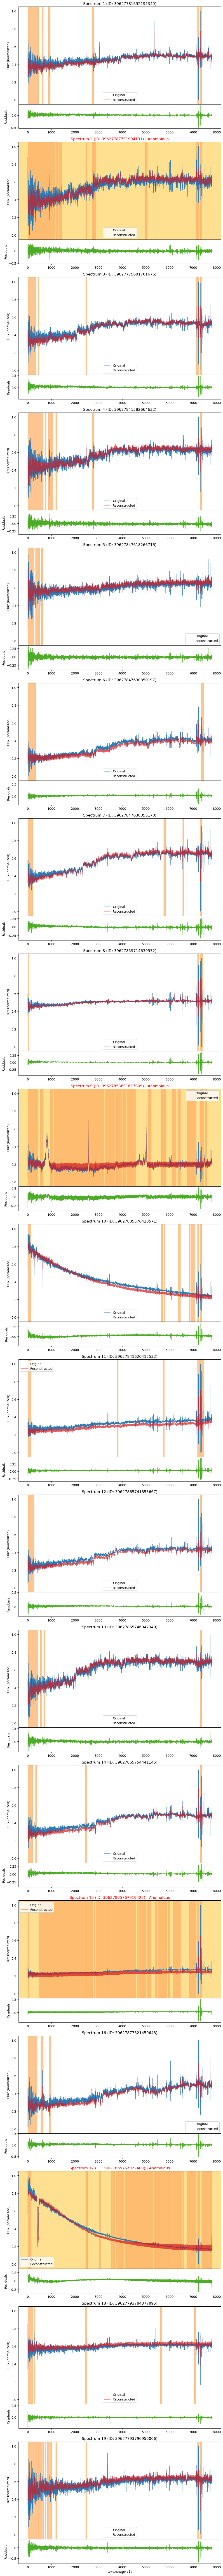

In [13]:
# Prepare tensors for model training
all_fluxes_tensor = torch.tensor(all_fluxes_padded, dtype=torch.float32).unsqueeze(1)
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(1)

# Model setup and initialization
autoencoder = CNNAutoencoderWithSkip()
reset_model_weights(autoencoder)

# Train the model
train_autoencoder(autoencoder, all_fluxes_tensor, mask_tensor)

# Evaluate the model and perform anomaly detection
autoencoder.eval()
reconstructed_fluxes = autoencoder(all_fluxes_tensor).detach().numpy().squeeze()

# Optimized anomaly detection with region-specific analysis
anomalous_regions, spectrum_anomalies = detect_anomalous_regions(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    window_size=50,
    percentile_threshold=95,
    range_mismatch_factor=1.5,
    overall_anomaly_threshold=0.3
)
print(f"Detected anomalous regions in spectra with improved method.")

# Plot the results, using dynamic naming
plot_spectra(
    original_fluxes=all_fluxes_tensor.numpy().squeeze(),
    reconstructed_fluxes=reconstructed_fluxes,
    anomalous_regions=anomalous_regions,
    spectrum_anomalies=spectrum_anomalies,
    zpix_cat=zpix_cat,
    save_directory=IMG_DIR  # Using dynamic naming path
)

# Optional: Visualize the autoencoder and its components if needed
#real_input = all_fluxes_tensor[0].unsqueeze(0)  # Select a real input sample

####### Uncomment when visualizations are required #########
# visualize_autoencoder(autoencoder, real_input)
# visualize_encoder(autoencoder, real_input)
# encoded_input = autoencoder.encoder3(autoencoder.encoder2(autoencoder.encoder1(real_input)))
# visualize_decoder(autoencoder, encoded_input)

# vvvvvvvvvvv DEBUG ZONE vvvvvvvvvvv

In [14]:
# def feedback_weighted_loss(output, target, mask, weight_factor=10):
#     """
#     Calculate a weighted loss using relative residuals as feedback.
#     Increases loss in regions where the model’s reconstruction deviates significantly.
    
#     Parameters:
#         output (Tensor): The reconstructed spectra from the model.
#         target (Tensor): The original spectra.
#         mask (Tensor): Padding mask, to ignore padded values in the loss calculation.
#         weight_factor (float): Factor to amplify the loss in high-residual regions.
        
#     Returns:
#         Tensor: Weighted loss value.
#     """
#     # Calculate the standard MSE loss
#     mse_loss = (output - target) ** 2
    
#     # Calculate relative residuals for feedback
#     relative_residuals = torch.abs((output - target) / (target + 1e-5))
    
#     # Amplify loss in areas with high relative residuals
#     weighted_loss = mse_loss * (1 + weight_factor * relative_residuals)
    
#     # Apply the mask to focus on unpadded values only
#     return (weighted_loss * mask).mean()


In [15]:
# def train_autoencoder(model, data, mask, epochs=100, batch_size=64, lr=0.001, loss_fn=None):
#     """
#     Train the autoencoder model with an optional custom loss function.

#     Parameters:
#         model (nn.Module): The autoencoder model.
#         data (Tensor): Training data tensor.
#         mask (Tensor): Padding mask tensor for the data.
#         epochs (int): Number of training epochs.
#         batch_size (int): Size of each training batch.
#         lr (float): Learning rate for the optimizer.
#         loss_fn (function): Custom loss function. If None, defaults to standard MSE loss.
#     """
#     # Default to standard MSE loss if no custom loss function is provided
#     if loss_fn is None:
#         loss_fn = lambda output, target, mask: ((output - target) ** 2 * mask).mean()
    
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     model.train()
    
#     for epoch in range(epochs):
#         epoch_loss = 0
#         for i in range(0, len(data), batch_size):
#             batch_data, mask_batch = data[i:i+batch_size], mask[i:i+batch_size]
#             optimizer.zero_grad()
            
#             # Calculate loss using the specified loss function
#             loss = loss_fn(model(batch_data), batch_data, mask_batch)
            
#             # Backpropagation and optimization
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()
        
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(data):.4f}")


In [16]:
# # Prepare tensors for model training
# all_fluxes_tensor = torch.tensor(all_fluxes_padded, dtype=torch.float32).unsqueeze(1)
# mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(1)

# # Model setup and initialization
# autoencoder = CNNAutoencoderWithSkip()
# reset_model_weights(autoencoder)


# # Train the model with feedback-weighted loss
# train_autoencoder(autoencoder, all_fluxes_tensor, mask_tensor, loss_fn=feedback_weighted_loss)

# # Evaluate the model and perform anomaly detection
# autoencoder.eval()
# reconstructed_fluxes = autoencoder(all_fluxes_tensor).detach().numpy().squeeze()

# # Optimized anomaly detection with region-specific analysis
# anomalous_regions, spectrum_anomalies = detect_anomalous_regions(
#     original_fluxes=all_fluxes_tensor.numpy().squeeze(),
#     reconstructed_fluxes=reconstructed_fluxes,
#     window_size=50,
#     percentile_threshold=95,
#     range_mismatch_factor=1.5,
#     overall_anomaly_threshold=0.3
# )
# print(f"Detected anomalous regions in spectra with improved method.")

# # Plot the results, using dynamic naming
# plot_spectra(
#     original_fluxes=all_fluxes_tensor.numpy().squeeze(),
#     reconstructed_fluxes=reconstructed_fluxes,
#     anomalous_regions=anomalous_regions,
#     spectrum_anomalies=spectrum_anomalies,
#     zpix_cat=zpix_cat,
#     save_directory=IMG_DIR  # Using dynamic naming path
# )
